In [158]:
import gc
import os,h5py
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from torchsummary import summary
# from model import resnet
import torch
from torch import nn,optim
from torchvision.models import resnet18
from torchvision.models import resnet34
import matplotlib.pyplot as plt
from tqdm import tqdm

In [159]:
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.activation import ReLU
# import torch
# resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
class Resnet(nn.Module):

  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(),
      nn.BatchNorm2d(),
      nn.MaxPool2d(),
      # nn.Conv2dAuto(), 
      nn.BatchNorm2d(), 
      nn.ResNetBasicBlock(), 
      nn.Conv2d(), 

      nn.ReLU(), 
      nn.Conv2d(), 
      nn.Conv2d(), 
      nn.Conv2d(),

      nn.Conv2d(), 
      nn.Conv2d(), 
      nn.Conv2d(), 
      nn.Conv2d(),

      nn.Conv2d(), 
      nn.Conv2d(), 
      nn.Conv2d(), 
      nn.Conv2d(),  
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  

In [160]:
EXAMPLE_DATA_ROOT_FOLDER = './MVTec company'

In [161]:
class TextureDataset(Dataset):
    filenames = {64: dict(train=('train64.csv', 'train64.h5'), test=('test64.csv', 'test64.h5')),
                 32: dict(train=('train32.csv', 'train32.h5'), test=('test32.csv','test32.h5'))}
                 
    indication_classes = ['index', 'angle', 'indication_type', 'indication_value', 'split']

    def __init__(self,root_folder, train=True, patch_size=64, classification=True, task='defect',keep_angles=True,keep_defects=False, transformation=None, test_sub_sample=200):
        if os.path.exists(root_folder):
            self.root_folder = root_folder
        else:
            raise IOError(f'The path of the directory is incorrect or doesn\'t exist for {root_folder}')
        
        self.patch_size = patch_size if patch_size in self.filenames.keys() else 32
        self.infos, self.data = self.load_data(train)

        if train:
            if classification:
                print('Classification Task:', end=' ')
                if task=='defect' and not keep_angles:    
                    self.infos = self.infos.loc[self.infos['angle']==0]
                    print('Drop all angles others than 0')
                elif task=='angle' and not keep_defects:
                    self.infos = self.infos.loc[self.infos['indication_type']=='good']
                    print('Drop all defect (all other than good)')
                else:
                    print('Keepíng all the data')
                    pass
            else:
                print('By default only keep healthy')
                self.infos = self.infos.loc[(self.infos['indication_type']=='good') & (self.infos['angle']==0)]
            self.data = self.data[self.infos.index]
        self.transformation = transforms.Compose([transforms.ToTensor()]) if transformation is None  else  transformation
        
        
        if not train and test_sub_sample:
            X = []
            newinfo = pd.DataFrame()
            for (a,t), df in self.infos.groupby(['angle','indication_type']):
                index = df.index
                subi = np.random.choice(index, test_sub_sample, replace=False)
                X.append(self.data[subi])
                newinfo = newinfo.append(self.infos.iloc[subi],ignore_index=True)
            self.infos = newinfo
            self.data = np.concatenate(X)
    
    def __len__(self):
        return self.infos.shape[0]
        
    def __getitem__(self,index):
        info = self.infos.iloc[index]
        angle, indication_value = int(info['angle'])//20, int(info['indication_value'])
        img = self.data[index]
        
        return self.transformation(img),angle, indication_value
            
    
    def load_data(self,train):
        files = self.filenames[self.patch_size]
        infos_filename, data_filename = files['train'] if train else files['test']
        
        infos = pd.read_csv(os.path.join(self.root_folder,infos_filename))
        data = None
        with h5py.File(os.path.join(self.root_folder,data_filename),mode='r') as h5file:
            data = h5file['images'][:]
        return infos, data        
    
    @staticmethod
    def get_angles_classes():
        return np.arange(8)* 20
    @staticmethod
    def get_indication_classes():
        return ['good', 'color', 'cut',  'hole', 'thread', 'metal_contamination']
    @staticmethod
    def compute_normalization_parameters(root):
        print('#### Compute Mean and Std of image for image scaling')
        dataset = TextureDataset(root_folder=root, classification=True,task='angle',keep_defects=False)
        loader = DataLoader(dataset,batch_size=15, num_workers=4, shuffle=True)
        mean = 0.
        std = 0.
        for images, _,_ in loader:
            batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)

        mean /= len(loader.dataset)
        std /= len(loader.dataset)
        print(f""" Normalize the data as following:
        transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize({mean}, {std} )])
        this function return the object Normalize the new mean and std: transforms.Normalize({mean}, {std} )
        """)
        return transforms.Normalize(mean, std )

In [162]:
class Trainer(object):
    def __init__(self, model,  modelname, optimizer, criterion,  train_loader, val_loader,no_epochs=5, device='cpu',target_type='defect',lr=1e-1, *args,**kwargs):
        
        assert target_type in ['angle','defect']
        self.no_epochs = no_epochs
        self.target_type = target_type
        self.model = model.to(device)
        self.modelname = modelname
        self.criterion = criterion
        self.optimizer = optimizer(self.model.parameters(),lr=lr) 
        
        self.train_loader, self.valid_loader = train_loader, val_loader
        print("Total_params",sum(p.numel() for p in model.parameters()))
        print("Trainable_params",sum(p.numel() for p in model.parameters() if p.requires_grad))
        self.device = device
        

    def train_an_epoch(self):
        self.model.train()
        train_loss = 0.0
        for data in tqdm(self.train_loader):
            
            if self.target_type =='angle':
                data, target, _ = data
            else:
                data, _, target = data
            data, target = data.to(self.device), target.to(self.device)
            # clear the gradients of all optimized variables
            self.optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.model(data)
            # calculate the batch loss
            loss = self.criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            self.optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
        return train_loss
        
    def valid_an_epoch(self):
        valid_loss = 0.0
        self.model.eval()
        
        OUTPUT = []
        TARGET = []
        for data in tqdm(self.valid_loader):
            if self.target_type =='angle':
                data, target, _ = data
            else:
                data, _, target = data
            data, target = data.to(self.device), target.to(self.device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.model(data)
            # calculate the batch loss
            loss = self.criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)            
            # converting raw _logits to softmax output
            output = nn.functional.softmax(output,dim=-1).detach().cpu().numpy()
            OUTPUT.append(np.argmax(output, axis=-1))
            TARGET.append(target.detach().cpu().numpy())
        return valid_loss, self.accuracy_per_class(np.concatenate(OUTPUT),np.concatenate(TARGET))
    
    def accuracy_per_class(self,ouput,target):
        matrix = confusion_matrix(target, ouput)
        return matrix.diagonal()/matrix.sum(axis=1), matrix
    
    def train(self):
        accuracy = []
        confusion = []
        alltrainloss = []
        allvalidloss = []
        for epoch in range(1, self.no_epochs+1):

            train_loss = self.train_an_epoch()
            valid_loss, accuracy_perclass = self.valid_an_epoch()
            train_loss = train_loss/len(self.train_loader.sampler)
            valid_loss = valid_loss/len(self.valid_loader.sampler)
            gc.collect()
            
            if epoch == 1:
                best_loss = valid_loss
            elif valid_loss < best_loss:
                best_loss = valid_loss
                torch.save(self.model.state_dict(), f"{self.modelname}.pt")

            alltrainloss.append(train_loss)
            allvalidloss.append(valid_loss)
            acc = accuracy_perclass[0].reshape(1,-1)
            conf = accuracy_perclass[1]
            accuracy.append(acc)
            confusion.append(conf)
            # print training/validation statistics 
            print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

        figure,axes = plt.subplots(1,2,figsize=(10,8))
        ax1,ax2= axes.ravel()
        linet, = ax1.plot(alltrainloss,label='Train')
        linev, = ax1.plot(allvalidloss,label='Valid')
        ax1.legend([linet,linev],['train','valid'])
        labels = TextureDataset.get_indication_classes() if self.target_type=='defect' else TextureDataset.get_angles_classes()
        lines = []
        for i, c in  zip(labels, np.concatenate(accuracy).T):
            line, = ax2.plot(c, label=i)
            lines.append(line)
        ax2.legend(lines,labels)

        bestIndex = allvalidloss.index(best_loss)
        print(f"Lowest validation loss achieved after epoch {bestIndex + 1}")
        bestAvg = 0
        for ind, acc in enumerate(accuracy):
            current = np.average(acc)
            if current > bestAvg:
                bestAvg = current
                bestAvgIndex = ind

        print(f"Best Model Accuracies: {accuracy[bestIndex]}\nBest Model Average: {np.average(accuracy[bestIndex])}\nBest Accuracy: {bestAvg} at epoch {bestAvgIndex+1}\nBest Model Confusion Matrix:\n{confusion[bestIndex]}")

In [169]:
class CNN(nn.Module):
    def __init__(self, nclasses, in_channel=1,*args,**kwargs):
        super(CNN, self).__init__()
        print(nclasses)
        self.encoder = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3),nn.BatchNorm2d(32),nn.ReLU(),
                                     nn.AvgPool2d(2),
                                     nn.Conv2d(32, 64, kernel_size=3),nn.BatchNorm2d(64),nn.ReLU(),
                                     nn.AvgPool2d(2),
                                     nn.Conv2d(64, 32, kernel_size=1),
                                     nn.AdaptiveAvgPool2d(1))
        self.l = nn.Linear(32, nclasses)
        
    def forward(self, x):
        x = self.encoder(x)
        x= x.view(x.shape[0],-1)
        return self.l(x)

In [164]:
def getdataloader(root, patch_size=64, task='defect',batch_size=32,keep_angles=False,test_sub_sample=False,num_workers=0, *args,**kwargs):
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.3541], [0.1352]), transforms.RandomErasing(0.3, value=0)])
    dataset = TextureDataset(root,train=True, classification=True, task=task, transformation=transformation,keep_angles=keep_angles)
    train_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers, pin_memory=True)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.3541], [0.1352])])
    dataset = TextureDataset(root,train=False, classification=True, task=task, transformation=transformation,test_sub_sample=test_sub_sample)
    val_loader = DataLoader(dataset=dataset,batch_size=int(batch_size*2),shuffle=False,num_workers=num_workers)
    return train_loader, val_loader
    
def get_model(modeltype='cnn',  nclasses=6, no_of_channels=1,*args,**kwargs):
    if modeltype =='resnet18': 
        model = resnet18(pretrained=True)
        model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.fc = torch.nn.Linear(model.fc.in_features, 6)
        
    elif modeltype =='resnet34': 
        model = resnet34(pretrained=True)
        model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.fc = torch.nn.Linear(model.fc.in_features, 6)
    else:model = CNN(nclasses=nclasses, in_channel=no_of_channels)
    return model, modeltype
        
    
def run(options):
    gc.collect()
    torch.cuda.empty_cache()
    train_loader, val_loader = getdataloader(**options)        
    model, modelname = get_model(**options)
    summary(model, (1,options['patch_size'],options['patch_size']),1,'cpu')
    trainer = Trainer(model=model, modelname=modelname, optimizer=optim.Adam, criterion=nn.CrossEntropyLoss(),  train_loader=train_loader, val_loader=val_loader, **options)
    trainer.train()
    gc.collect()
    model.eval()

**ResNet18**

Classification Task: Keepíng all the data


C:\Users\Playtech\AppData\Local\Temp\ipykernel_5128\1650925562.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  newinfo = newinfo.append(self.infos.iloc[subi],ignore_index=True)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 16, 16]           3,136
       BatchNorm2d-2            [1, 64, 16, 16]             128
              ReLU-3            [1, 64, 16, 16]               0
         MaxPool2d-4              [1, 64, 8, 8]               0
            Conv2d-5              [1, 64, 8, 8]          36,864
       BatchNorm2d-6              [1, 64, 8, 8]             128
              ReLU-7              [1, 64, 8, 8]               0
            Conv2d-8              [1, 64, 8, 8]          36,864
       BatchNorm2d-9              [1, 64, 8, 8]             128
             ReLU-10              [1, 64, 8, 8]               0
       BasicBlock-11              [1, 64, 8, 8]               0
           Conv2d-12              [1, 64, 8, 8]          36,864
      BatchNorm2d-13              [1, 64, 8, 8]             128
             ReLU-14              [1, 6

100%|██████████| 12/12 [00:01<00:00,  7.45it/s]


Epoch: 1 	Training Loss: 0.511294 	Validation Loss: 1.065117


100%|██████████| 12/12 [00:01<00:00,  7.54it/s]


Epoch: 2 	Training Loss: 0.196464 	Validation Loss: 1.526151


100%|██████████| 12/12 [00:01<00:00,  7.53it/s]


Epoch: 3 	Training Loss: 0.120737 	Validation Loss: 1.661237


100%|██████████| 12/12 [00:01<00:00,  7.52it/s]


Epoch: 4 	Training Loss: 0.085373 	Validation Loss: 1.689679


100%|██████████| 12/12 [00:01<00:00,  6.65it/s]


Epoch: 5 	Training Loss: 0.066705 	Validation Loss: 1.936599
Lowest validation loss achieved after epoch 1
Best Model Accuracies: [[0.94375  0.936875 0.555625 0.346875 0.479375 0.9325  ]]
Best Model Average: 0.6991666666666667
Best Accuracy: 0.7071875 at epoch 5
Best Model Confusion Matrix:
[[1510   14   40   23    6    7]
 [  41 1499   27   27    1    5]
 [ 224   17  889  432   29    9]
 [ 137    3  795  555   87   23]
 [  41   65  403  255  767   69]
 [   3    7   10   25   63 1492]]


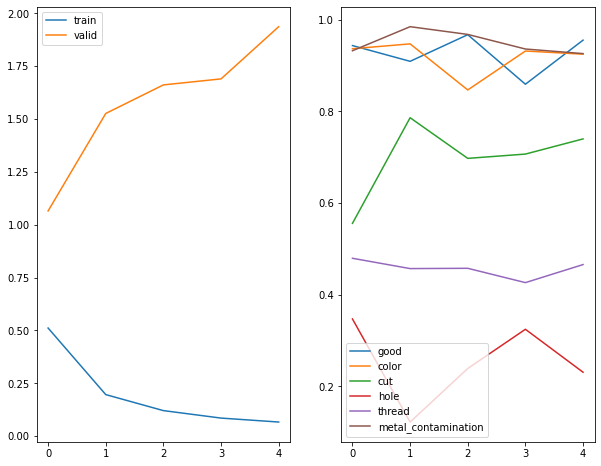

In [165]:
parameter_dict=dict(root=EXAMPLE_DATA_ROOT_FOLDER, patch_size=32, batch_size=400, task='defect', nclasses = len(TextureDataset.get_indication_classes()), 
                    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), lr=5e-4, no_epochs=5, keep_angles=True, test_sub_sample=200,num_workers=0, modeltype='resnet18')
run(parameter_dict)

**CNN**

Classification Task: Keepíng all the data


C:\Users\Playtech\AppData\Local\Temp\ipykernel_5128\1650925562.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  newinfo = newinfo.append(self.infos.iloc[subi],ignore_index=True)


6
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 30, 30]             320
       BatchNorm2d-2            [1, 32, 30, 30]              64
              ReLU-3            [1, 32, 30, 30]               0
         AvgPool2d-4            [1, 32, 15, 15]               0
            Conv2d-5            [1, 64, 13, 13]          18,496
       BatchNorm2d-6            [1, 64, 13, 13]             128
              ReLU-7            [1, 64, 13, 13]               0
         AvgPool2d-8              [1, 64, 6, 6]               0
            Conv2d-9              [1, 32, 6, 6]           2,080
AdaptiveAvgPool2d-10              [1, 32, 1, 1]               0
           Linear-11                     [1, 6]             198
Total params: 21,286
Trainable params: 21,286
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

100%|██████████| 12/12 [00:01<00:00,  7.83it/s]


Epoch: 1 	Training Loss: 1.440154 	Validation Loss: 1.372080


100%|██████████| 12/12 [00:01<00:00,  8.27it/s]


Epoch: 2 	Training Loss: 1.211745 	Validation Loss: 1.129584


100%|██████████| 12/12 [00:01<00:00,  6.96it/s]


Epoch: 3 	Training Loss: 1.049290 	Validation Loss: 0.990211


100%|██████████| 12/12 [00:01<00:00,  7.04it/s]


Epoch: 4 	Training Loss: 0.986018 	Validation Loss: 0.962176


100%|██████████| 12/12 [00:01<00:00,  7.02it/s]


Epoch: 5 	Training Loss: 0.946544 	Validation Loss: 0.954710
Lowest validation loss achieved after epoch 5
Best Model Accuracies: [[0.6475   0.800625 0.640625 0.235625 0.468125 0.970625]]
Best Model Average: 0.6271875000000001
Best Accuracy: 0.6271875000000001 at epoch 5
Best Model Confusion Matrix:
[[1036    0  143  258   49  114]
 [  14 1281  174   58    7   66]
 [ 190   63 1025  275   21   26]
 [ 253   14  864  377   59   33]
 [  81   90  489  121  749   70]
 [   5    6   32    4    0 1553]]


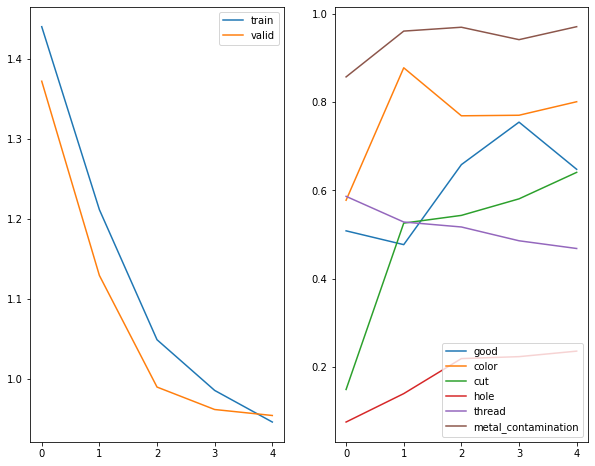

In [170]:
parameter_dict=dict(root=EXAMPLE_DATA_ROOT_FOLDER, patch_size=32, batch_size=400, task='defect', nclasses = len(TextureDataset.get_indication_classes()), 
                    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), lr=5e-4, no_epochs=5, keep_angles=True, test_sub_sample=200,num_workers=0, modeltype='cnn')

run(parameter_dict)

**ResNet34**

Classification Task: Keepíng all the data


C:\Users\Playtech\AppData\Local\Temp\ipykernel_5128\1650925562.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  newinfo = newinfo.append(self.infos.iloc[subi],ignore_index=True)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 16, 16]           3,136
       BatchNorm2d-2            [1, 64, 16, 16]             128
              ReLU-3            [1, 64, 16, 16]               0
         MaxPool2d-4              [1, 64, 8, 8]               0
            Conv2d-5              [1, 64, 8, 8]          36,864
       BatchNorm2d-6              [1, 64, 8, 8]             128
              ReLU-7              [1, 64, 8, 8]               0
            Conv2d-8              [1, 64, 8, 8]          36,864
       BatchNorm2d-9              [1, 64, 8, 8]             128
             ReLU-10              [1, 64, 8, 8]               0
       BasicBlock-11              [1, 64, 8, 8]               0
           Conv2d-12              [1, 64, 8, 8]          36,864
      BatchNorm2d-13              [1, 64, 8, 8]             128
             ReLU-14              [1, 6

100%|██████████| 14/14 [00:01<00:00,  7.56it/s]


Epoch: 1 	Training Loss: 0.494122 	Validation Loss: 1.891462


100%|██████████| 14/14 [00:01<00:00,  7.46it/s]


Epoch: 2 	Training Loss: 0.197753 	Validation Loss: 1.411384


100%|██████████| 14/14 [00:02<00:00,  6.61it/s]


Epoch: 3 	Training Loss: 0.120769 	Validation Loss: 1.575547


100%|██████████| 14/14 [00:02<00:00,  6.32it/s]


Epoch: 4 	Training Loss: 0.093965 	Validation Loss: 1.681241


100%|██████████| 14/14 [00:02<00:00,  6.35it/s]


Epoch: 5 	Training Loss: 0.075278 	Validation Loss: 2.183626
Lowest validation loss achieved after epoch 2
Best Model Accuracies: [[0.900625 0.89875  0.650625 0.424375 0.394375 0.8925  ]]
Best Model Average: 0.6935416666666666
Best Accuracy: 0.6935416666666666 at epoch 2
Best Model Confusion Matrix:
[[1441   11   88   51    9    0]
 [  28 1438  110   23    0    1]
 [  89    0 1041  467    3    0]
 [  61    1  852  679    6    1]
 [  18   49  488  394  631   20]
 [  13   11   25   75   48 1428]]


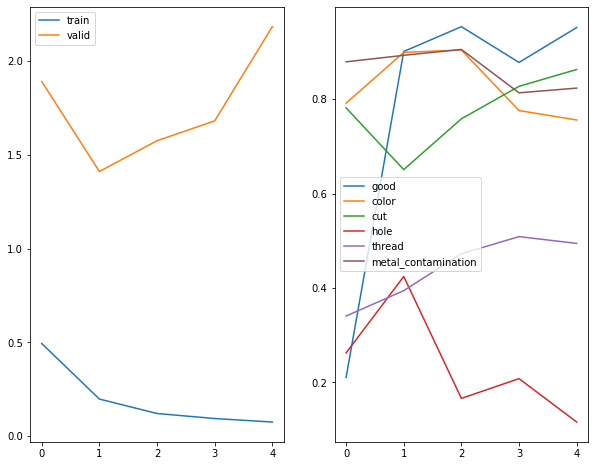

In [167]:
parameter_dict=dict(root=EXAMPLE_DATA_ROOT_FOLDER, patch_size=32, batch_size=350, task='defect', nclasses = len(TextureDataset.get_indication_classes()), 
                    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), lr=5e-4, no_epochs=5, keep_angles=True, test_sub_sample=200,num_workers=0, modeltype='resnet34')
run(parameter_dict)

In [168]:
import os

print(os.getcwd())


c:\Users\Playtech\Documents\git\p4p-personal
